# Documentation

**Calculate Summer Anomalies from CMIP6 Data** 

**Spencer Ressel & Pedro Angulo Umaña**

April 4th, 2023

This notebook analyzes data from the Detection and Attribution Model Intercomparison Project (DAMIP): https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1062-modelling-cmip6-damip

Specifically, daily maximum temperature, outgoing longwave radiation (OLR), and sea surface temperatures (SST) are used to study the effects of climate change on heat waves over the Korean peninsula. This work is part of the CATER project.


# Imports

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify models, experiments, and variables

In [2]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-nat', 'hist-GHG']

korean_peninsula = dict(lat=slice(34, 38), lon=slice(125, 130))
reference_period = dict(year=slice(1951, 1980))

# Do calculation

In [3]:
from glob import glob
import xarray as xr
for model in models_list:
        for exp in experiments_list:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)
            
            # Load the data
            file_name = sorted(glob('./' + exp + '/compiled_tasmax_*.nc'))[0]
            [
                variable, 
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
            
            temperature_data = xr.open_dataset(file_name)['tasmax']
            
            # Subset the data to fit the Korean peninsula 
            daily_maximum_temperature_korea = temperature_data.sel(korean_peninsula).mean(dim=['lat', 'lon'])
            
            # Compute the mean summer temperature for each year
            summer_mean_max_temperature_by_year = daily_maximum_temperature_korea.sel(
                time=daily_maximum_temperature_korea['time.month'].isin([7,8])
            ).groupby('time.year').mean()
            
            # Compute the mean temperature of the reference period
            reference_period_mean_temperature = summer_mean_max_temperature_by_year.sel(
                reference_period
            ).mean()
            
            # Compute anomalies from reference period
            summer_temperature_anomalies = summer_mean_max_temperature_by_year - reference_period_mean_temperature
            
            # Create new file to save temperature anomalies
            new_file_name = (
                'tasmax_anomalies-1951-1980_' 
                + frequency 
                + '_' + model 
                + '_' + exp
                + '_' + variant 
                + '_' + grid
                + '_' + period
                + '.nc'
            )
            
            # xr.open_dataset(new_file_name)
            # Save output to netCDF
            summer_temperature_anomalies.to_netcdf('./' + exp + '/' + new_file_name)
            # print('./' + exp + '/' + new_file_name)
            # print(summer_temperature_anomalies[:5])

# Plot temperature anomalies

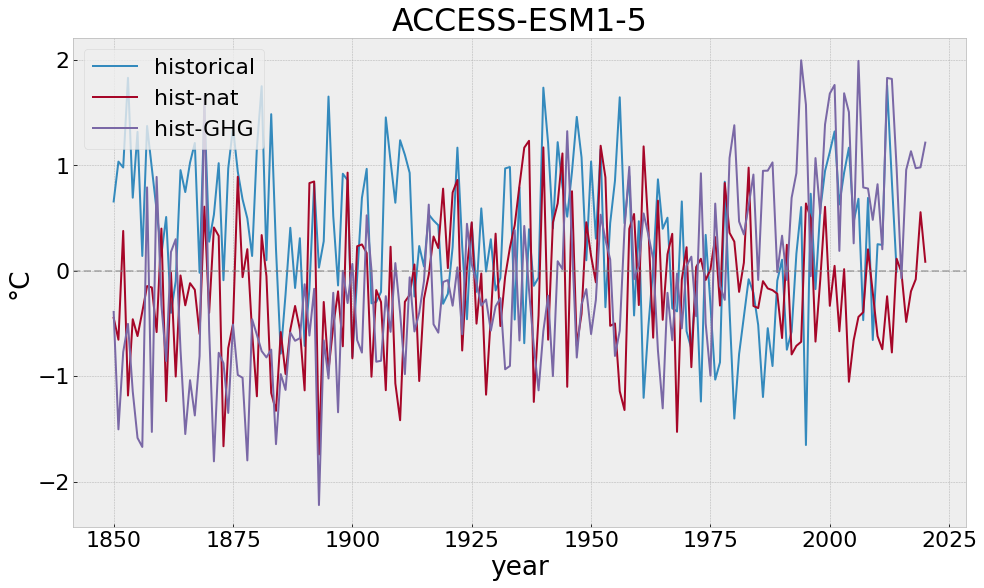

In [5]:
models_list = ['ACCESS-ESM1-5']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

for model in models_list:
    temperature_anomalies = {}
    for exp in experiments_list:
        # Set the directory
        os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
        file_name = sorted(glob('tasmax_anomalies*.nc'))[0]
        [
            variable, 
            reference_period,
            frequency, 
            model_name, 
            experiment, 
            variant, 
            grid, 
            period
        ] = file_name.split('.nc')[0].split('_')
        temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']

    [fig, ax] = plt.subplots(figsize=(16,9))
    ax.plot(
        temperature_anomalies[model + '_historical'].year, 
        temperature_anomalies[model + '_historical'],
        color='#348ABD',
        label='historical'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-nat'].year, 
        temperature_anomalies[model + '_hist-nat'],
        color='#A60628',
        label='hist-nat'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-GHG'].year, 
        temperature_anomalies[model + '_hist-GHG'],
        color='#7A68A6',
        label='hist-GHG'
    )
    ax.axhline(y=0, color='gray', alpha=0.5, ls='--')
    
    ax.legend(loc='upper left')
    ax.set_title(model)
    ax.set_ylabel('°C')
    ax.set_xlabel('year')
    # ax.set_aspect(50)
    
    plt.show()


In [144]:
temperature_anomalies['ACCESS-ESM1-5_hist-GHG']

<xarray.DataArray 'tasmax' (year: 171)>
array([-0.033112, -1.362427, -0.849884, -0.096588, -0.010956,  0.212219,
       -0.29718 , -0.625214, -0.415405, -0.693909, -0.034393,  0.118683,
       -0.461243, -1.574341, -0.373657, -1.0383  , -0.747742, -0.744049,
       -1.691437, -0.392822, -0.845459, -0.807312, -1.295959,  0.409882,
       -0.287811,  0.267334, -0.249695, -0.340088, -0.340057,  0.809235,
       -0.385101, -0.073975, -0.453644, -0.448547, -0.652435, -1.404694,
       -0.539307, -0.154388, -0.576935, -1.484375, -0.7276  ,  0.087402,
       -0.416199, -0.961029, -0.638855, -1.029114, -1.338409, -0.599915,
        0.026825, -0.713562, -0.736237, -0.545441, -0.444427,  0.419281,
        0.012421, -0.955261,  0.083069, -0.066833, -0.094849, -1.060669,
        0.039185,  0.096222, -0.490021,  0.590912, -0.911163, -0.416016,
       -0.157715,  0.262054,  0.388611, -0.325287,  0.97644 , -0.141327,
        0.189331, -0.824585, -0.117859, -0.720093, -0.247955, -0.881409,
        0.721558, -0.228516, -1.437958, -0.012939, -0.263672, -0.792572,
       -0.248749, -0.119354, -0.942627, -0.543518, -0.454285,  0.186188,
       -0.427277,  0.229279, -0.02652 , -1.259033, -0.303223, -0.553497,
       -0.056274,  0.530701, -0.726257, -0.133698,  0.495361,  0.072113,
       -0.500793,  0.260406,  0.343689, -0.925964, -0.217834, -0.047974,
       -1.102539, -0.911072,  0.706146, -1.707184,  0.051208,  0.234619,
       -0.63205 ,  0.273773,  0.319794,  0.568359,  0.18866 ,  0.039612,
       -0.165253, -0.936005,  0.272827,  0.635803,  0.113373,  0.155914,
        1.139099,  0.319641,  0.93634 , -0.121185,  0.636139,  0.063477,
        0.806305,  0.226318,  0.562927, -0.172089,  0.608063,  0.777863,
        1.167236,  0.086853,  0.402313,  0.770874,  0.325806,  0.208588,
        0.980377,  1.355133,  0.661316, -0.11377 ,  0.493042, -0.380157,
        0.067749,  0.591431,  0.531891,  1.089478, -0.39563 ,  0.735168,
        0.494843,  0.49353 ,  1.30545 ,  1.037842,  1.551575,  1.173615,
        1.454529,  1.205597,  0.369537,  0.909821,  0.252686,  0.374298,
        1.275024,  0.891724, -0.110565], dtype=float32)
Coordinates:
    height   float64 ...
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2016 2017 2018 2019 2020

In [145]:
reference_period

'anomalies-1951-1980'